In [66]:
%matplotlib inline

from math import *
import numpy as np
from matplotlib import pyplot as plt
import time as t


class Func:
    def __init__(self):
        pass

    def __call__(self, x):
        x, y = x
        return (1 - y ** 2) * x ** 2 * exp(-x ** 2) + .5 * y ** 2

    def grad(self, x):
        x, y = x[0, 0], x[1, 0]

        dEdx = 2 * (1 - y ** 2) * exp(-x ** 2) * (x - x ** 3)
        dEdy = (1 - 2 * x ** 2 * exp(-x ** 2)) * y
        return np.matrix([[dEdx], [dEdy]])

    def hess(self, x):
        x, y = x[0, 0], x[1, 0]

        xx = 2 * (1 - y ** 2) * exp(-x ** 2) * (2 * x ** 4 - 5 * x ** 2 + 1)
        xy = 4 * y * exp(-x ** 2) * x * (x - 1) * (x + 1);
        yy = 1 - 2 * x ** 2 * exp(-x ** 2)

        return np.matrix([[xx, xy], [xy, yy]])

    
class Func3:
    def __init__(self):
        self.inner = Func()

    def __call__(self, x):
        return self.inner(x[:2]) + self.inner(x[1:])
        
    def grad(self, x):
        grad = np.matrix(np.zeros((3, 1))) 
        grad[:2, 0] = self.inner.grad(x[:2])
        grad[1:, 0] = self.inner.grad(x[1:])
        
        return grad
        
    def hess(self, x):
        hess = np.matrix(np.zeros((3, 3)))
        hess[:2, :2] = self.inner.hess(x[:2])
        hess[1:, 1:] = self.inner.hess(x[1:])
        
        return hess
    
    
def r(x):
    return np.linalg.norm(x) - .3


def get_drdq(x):
    return 2 * x


def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q


def get_rfo_step(grad, hess, beta):
    M = np.matrix(np.block([[0, grad.T], [grad, hess]]))

    Z1 = np.matrix(np.zeros((1, nInter - nLambda)))
    Z2 = np.matrix(np.ones((1, 1)))
    S = np.matrix(np.eye(nInter - nLambda, nInter - nLambda))
    S = np.bmat([[Z2, Z1], [Z1.getT(), beta * S]])
    
    print(S)
    
    M = S.getI() * M

    w, v = np.linalg.eigh(M)
    dx = v[1:, 0] / v[0, 0]
    print('!', type(dx), dx)
    return dx


def construct_T(drdq):
    T = np.matrix(np.zeros((nInter, nInter)))
    drdq = drdq.getT()

    T[:nLambda] = drdq

    for i in range(nInter - nLambda):
        T[i + nLambda, i] = 1;

    T = gram_schmidt_columns(T.getT()).getT()

    return T


def construct_T_b(T):
    T_b = np.matrix(np.zeros((nLambda, nInter)))
    for i in range(nLambda):
        for j in range(nInter):
            T_b[i, j] = T[i, j]
    T_b = T_b.getT()
    return T_b


def construct_T_ti(T):
    T_ti = np.matrix(np.zeros((nInter - nLambda, nInter)))
    for i in range(nInter - nLambda):
        for j in range(nInter):
            T_ti[i, j] = T[i + nLambda, j]

    T_ti = T_ti.getT()

    return T_ti


def construct_dy(drdq, T_b, r):
    tmp = drdq.getT() * T_b
    tmp = tmp.getI()
    print('!', tmp)
    dy = tmp * r
    dy *= -1

    return dy


def construct_x(q, T_ti):
    x = T_ti.getT() * q
    return x


def construct_dx(dq, T_ti):
    dx = T_ti.getT() * dq
    return dx


def construct_reduced_grad(dEdq, W, dy, T_b, T_ti):
    tmp1 = dEdq
    tmp2 = W * T_b
    tmp3 = tmp2 * dy
    tmp1 = -tmp3 + tmp1
    red_grad = T_ti.getT() * tmp1

    return red_grad


def construct_reduced_hess(W, T_ti):
    tmp = T_ti.getT() * W
    red_hess = tmp * T_ti

    return red_hess


def construct_lambda(drdq, dEdq):
    tmp = drdq.getT() * drdq
    tmp.getI()
    tmp = tmp * drdq.getT()
    rLambda = tmp * dEdq

    return rLambda


def compute_norm(vect_col):
    norm = 0
    for i in vect_col:
        norm += float(i) * float(i)
    norm = norm ** (0.5)

    return norm


def construct_h(dEdq, drdq):
    lambdas = construct_lambda(drdq, dEdq)
    h = np.matrix(np.zeros((1, nInter)))

    h = dEdq - drdq * lambdas
    return h


def bfgs_update_W(prev_W, prev_grad_W, delta_q, dEdq, drdq):
    s_k = delta_q
    y_k = construct_h(dEdq, drdq) - prev_grad_W

    tmp1 = y_k * y_k.getT()
    tmp2 = y_k.getT() * s_k
    tmp3 = prev_W * s_k * s_k.getT() * prev_W
    tmp4 = s_k.getT() * prev_W * s_k

    W = prev_W - tmp3 / tmp4 + tmp1 / tmp2

    return W


def plot(xs, ys, func):
    plt.figure(figsize=(10, 10))

    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1, 2, 100)
    x_grid, y_grid = np.meshgrid(x, y)

    z_E = np.zeros_like(x_grid)
    for i, (row_x, row_y) in enumerate(zip(x_grid, y_grid)):
        for j, (x, y) in enumerate(zip(row_x, row_y)):
            z_E[i, j] = func([x, y])

    z_r = np.zeros_like(x_grid)
    for i, (row_x, row_y) in enumerate(zip(x_grid, y_grid)):
        for j, (x, y) in enumerate(zip(row_x, row_y)):
            z_r[i, j] = r([x, y])

    # plt.figure(figsize=(50, 50))
    plt.contour(x_grid, y_grid, z_E, 200)
    plt.contour(x_grid, y_grid, z_r, [0], colors='black')
    plt.plot(xs, ys, c='r')

In [106]:
# np.array([1, 0]).dot(np.array([[0, 0], [1, 0]]))
np.array([[0, 0], [1, 0]]).dot(np.array([1, 0]))

array([0, 1])

[[-9.50271051 -0.35260678]
 [-0.35260678 -9.66849711]]


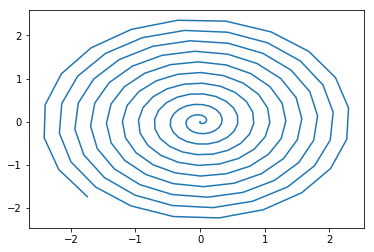

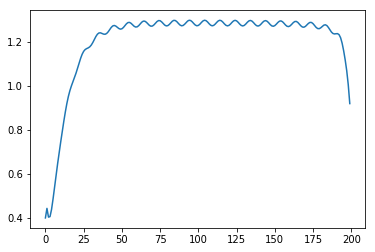

In [122]:
H = np.array([[-10., -.1], [.3, -10]])

def f(x):
    return .5 * x.T.dot(H).dot(x)

def grad(x):
    return H.dot(x)

def hess(x):
    return H

def BFGS(B, s, y):
    return B + np.outer(y, y) / y.dot(s) - np.outer(B.dot(s), B.dot(s).T) / s.dot(B).dot(s)

q = np.random.randn(2)
q_prev = q
grad_prev = grad(q)
B = np.array([[-10, 0], [0, -10]])#hess(q_prev)

N = 20
M = 200

xs = []
ys = []
norms = []

for i in np.linspace(0, N * pi, M):
    q_next = q.dot(np.array([[sin(i), cos(i)], [-cos(i), sin(i)]])) * (1 - i / (N * pi))
    grad_next = grad(q_next)

    B = BFGS(B, q_next - q_prev, grad_next - grad_prev)
    
    xs.append(q_next[0])
    ys.append(q_next[1])
    norms.append(np.linalg.norm(hess(q_next) - B))
    
    q_prev, grad_prev = q_next, grad_next
    
    if i > 150:
        break
print(B)
    
    
plt.plot(xs, ys)
plt.show()
plt.plot(norms)

! [[-0.42328957]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
! <class 'numpy.matrixlib.defmatrix.matrix'> [[-0.0056145 ]
 [ 0.04264505]]
0 step_rest = 1.0, grad = [[ 0.02882974]
 [-0.33281177]], hess = [[8.07151375 0.38851755]
 [0.38851755 7.84102677]]
x = 0.3255494507032739, y =-0.5955775248172714
! [[-0.61777579]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
! <class 'numpy.matrixlib.defmatrix.matrix'> [[0.02648535]
 [0.01320955]]
1 step_rest = 1.0, grad = [[-0.1516783 ]
 [-0.07707263]], hess = [[5.62934972 0.185446  ]
 [0.185446   5.45775879]]
x = 0.1747315272648991, y =-0.3804461430256577
! [[-1.00893423]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
! <class 'numpy.matrixlib.defmatrix.matrix'> [[ 0.04635117]
 [-0.06095342]]
2 step_rest = 1.0, grad = [[-0.11267459]
 [ 0.12482884]], hess = [[2.59023382 0.1309285 ]
 [0.1309285  2.13466976]]
x = 0.06178501471830637, y =-0.2075181360368028
! [[-1.62376667]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
! <class 'numpy.matrixlib.defmatrix.matrix'> [[ 0.02178046]
 [-0

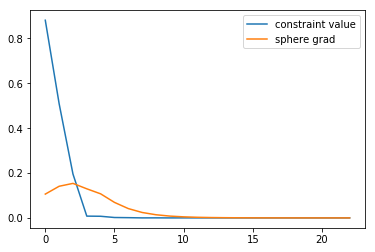

In [74]:
nLambda = 1
nInter = 3

func = Func3()

q = np.matrix(np.random.randn(3, 1))
# q = np.matrix([[-0.01], [0.05]])

constr_value = []
sphere_grad_value = [] 

start_time = t.time()

x_beta = 1.0
y_beta = 1.0
g_beta = 1.0
beta = 4
k_max = 1000

for i in range(k_max):
    constr_value.append(r(q))
    
    sphere_grad = func.grad(q) - q * func.grad(q).T.dot(q) / np.linalg.norm(q) ** 2
    sphere_grad_value.append(np.linalg.norm(sphere_grad))

    #    print('x = {}, y = {}'.format(q[0, 0], q[1, 0]))
    dEdq = func.grad(q)
    drdq = get_drdq(q)

    l0 = construct_lambda(drdq, dEdq)
    W = func.hess(q) + l0[0, 0] * 2 * np.identity(nInter)

    T = construct_T(drdq)
    T_b = construct_T_b(T)
    T_ti = construct_T_ti(T)
    delta_y = construct_dy(drdq, T_b, r(q))

    grad = construct_reduced_grad(dEdq, W, delta_y, T_b, T_ti)
    hess = construct_reduced_hess(W, T_ti)

    if np.linalg.norm(grad) < 10 ** (-5):
        print("True")
        break

#     step_rest = beta * max(y_beta * min(x_beta, g_beta), 1 / 10)
    #    step_rest = max(beta * y_beta * min(x_beta, g_beta), beta * 1 / 10)
    step_rest = 1.
    
    delta_x = get_rfo_step(grad, hess, step_rest)

    print('{} step_rest = {}, grad = {}, hess = {}'.format(i, step_rest, grad, hess))
    dy = beta
    g = beta
    dx = beta

    sf = 2 ** (0.5)

    norm_deltay = compute_norm(delta_y)
    norm_deltax = compute_norm(delta_x)
    norm_red_grad = compute_norm(grad)

    if dy < 0.75 * norm_deltay or norm_deltay < 10 ** (-2):
        y_beta = min(2, y_beta * sf)
    elif dy > 1.25 * norm_deltay and dy >= 10 ** (-5):
        y_beta = max(1 / 10, y_beta / sf)
        dy = norm_deltay

    if i != k_max:
        if dx < norm_deltax < beta:
            x_beta = min(1, x_beta * sf)
        elif dx > 1.25 * norm_deltax or dx >= beta:
            x_beta = max(1 / 5, x_beta / sf)
            dx = norm_deltax

    if g < 0.75 * norm_red_grad and g < beta:
        g_beta = min(1, g_beta * sf)
    elif g > 1.25 * norm_red_grad or g >= beta:
        g_beta = max(1 / 5, g_beta / sf)
        g = norm_red_grad
        
    dq = T_b * delta_y + T_ti * delta_x
    q += dq

    print('x = {}, y ={}'.format(q[0, 0], q[1, 0]))

# print("time:", (t.time() - start_time))
# plot(xs, ys, func)
# plt.show(block=True)

print(constr_value)
print(sphere_grad_value)

plt.plot(constr_value, label='constraint value')
plt.plot(sphere_grad_value, label='sphere grad')
plt.legend()

! [[9.80580676]]
0 step_rest = 1, grad = [[0.45248809]], hess = [[1.95645361]]
x = -0.7046691244406296, y =2.401164223752595
! [[0.19980591]]
1 step_rest = 1, grad = [[2.37439228]], hess = [[89.6518999]]
x = -0.6061463556825208, y =1.9714608876418667
! [[0.24241954]]
2 step_rest = 1, grad = [[2.27688513]], hess = [[69.96303773]]
x = -0.5116516948544956, y =1.553500565311862
! [[0.30570027]]
3 step_rest = 1, grad = [[1.69093138]], hess = [[45.14332388]]
x = -0.4194560138975314, y =1.1540012341646988
! [[0.40720958]]
4 step_rest = 1, grad = [[0.94403098]], hess = [[21.55004233]]
x = -0.3314743199760054, y =0.7839582745906566
! [[0.58743668]]
5 step_rest = 1, grad = [[0.29968756]], hess = [[7.49896908]]
x = -0.2421357662156871, y =0.47021154129462245
! [[0.94536942]]
6 step_rest = 1, grad = [[-0.06944562]], hess = [[2.58733612]]
x = -0.1192240672178869, y =0.290110543081777
! [[1.5941159]]
7 step_rest = 1, grad = [[-0.09244539]], hess = [[1.83930901]]
x = -0.06457931594998488, y =0.289035

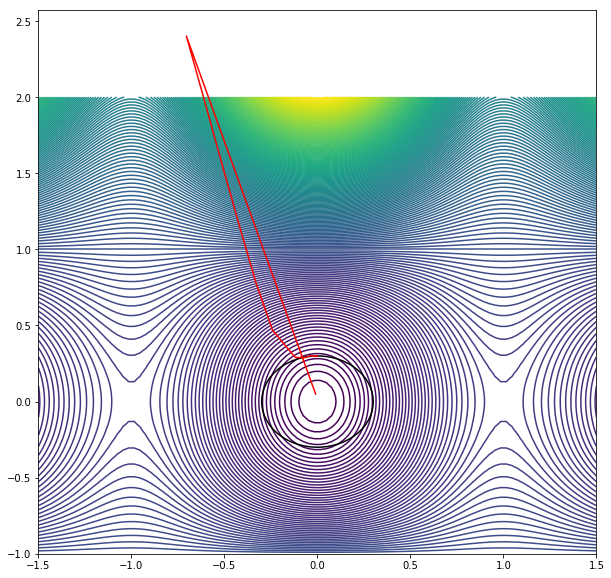

In [48]:
'''!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'''
nLambda = 1
nInter = 2

func = Func()

# q = np.matrix(np.random.randn(2, 1))
q = np.matrix([[-0.01], [0.05]])

xs = []
ys = []

start_time = t.time()

x_beta = 1.0
y_beta = 1.0
g_beta = 1.0
beta = 4
k_max = 1000

for i in range(k_max):
    xs.append(q[0, 0])
    ys.append(q[1, 0])
    
    #    print('x = {}, y = {}'.format(q[0, 0], q[1, 0]))
    dEdq = func.grad(q)
    drdq = get_drdq(q)

    l0 = construct_lambda(drdq, dEdq)
    W = func.hess(q) + l0[0, 0] * 2 * np.identity(nInter)

    T = construct_T(drdq)
    T_b = construct_T_b(T)
    T_ti = construct_T_ti(T)
    delta_y = construct_dy(drdq, T_b, r(q))

    grad = construct_reduced_grad(dEdq, W, delta_y, T_b, T_ti)
    hess = construct_reduced_hess(W, T_ti)

    if abs(float(grad)) < 10 ** (-5):
        print("True")
        break

    step_rest = beta * max(y_beta * min(x_beta, g_beta), 1 / 10)
    #    step_rest = max(beta * y_beta * min(x_beta, g_beta), beta * 1 / 10)
    step_rest = 1
    
    delta_x = get_rfo_step(grad, hess, step_rest)

    print('{} step_rest = {}, grad = {}, hess = {}'.format(i, step_rest, grad, hess))
    dy = beta
    g = beta
    dx = beta

    sf = 2 ** (0.5)

    norm_deltay = compute_norm(delta_y)
    norm_deltax = compute_norm(delta_x)
    norm_red_grad = compute_norm(grad)

    if dy < 0.75 * norm_deltay or norm_deltay < 10 ** (-2):
        y_beta = min(2, y_beta * sf)
    elif dy > 1.25 * norm_deltay and dy >= 10 ** (-5):
        y_beta = max(1 / 10, y_beta / sf)
        dy = norm_deltay

    if i != k_max:
        if dx < norm_deltax < beta:
            x_beta = min(1, x_beta * sf)
        elif dx > 1.25 * norm_deltax or dx >= beta:
            x_beta = max(1 / 5, x_beta / sf)
            dx = norm_deltax

    if g < 0.75 * norm_red_grad and g < beta:
        g_beta = min(1, g_beta * sf)
    elif g > 1.25 * norm_red_grad or g >= beta:
        g_beta = max(1 / 5, g_beta / sf)
        g = norm_red_grad
        
    dq = T_b * delta_y + T_ti * delta_x
    q += dq

    print('x = {}, y ={}'.format(q[0, 0], q[1, 0]))

print("time:", (t.time() - start_time))
plot(xs, ys, func)
plt.show(block=True)